# chp02-Introduction(2013)

>因为我在做第三章的笔记时，才发现作者已经在2017推出了第二版，但难得写了这么多，就留下来了，所以这里的chp02-Introduction(2013)指的是2013年第一版的第二章，这一章的内容主要是直接使用pandas对一些数据集进行数据分析，可以说是实战篇。不过在2017年的第二版中，这一章的内容被移到了第十四章，内容为14.1，14.2，14.3。第十四章中把不同的数据集分成了不同的小节，阅读起来会更方便一些，而且有很多地方做了优化，推荐大家直接看第十四章的内容。

# 读取来自bit.ly的1.use.gov数据

这个数据集是bit.ly和美国政府网站use.gov合作，提供了一份从生成.gov或.mil短链接的用户那里手机来的匿名数据。

下面文中的各行格式为JSON，这里读取第一行看一看是什么东西

In [4]:
path = '../datasets/bitly_usagov/example.txt'

In [5]:
open(path).readline()

'{ "a": "Mozilla\\/5.0 (Windows NT 6.1; WOW64) AppleWebKit\\/535.11 (KHTML, like Gecko) Chrome\\/17.0.963.78 Safari\\/535.11", "c": "US", "nk": 1, "tz": "America\\/New_York", "gr": "MA", "g": "A6qOVH", "h": "wfLQtf", "l": "orofrog", "al": "en-US,en;q=0.8", "hh": "1.usa.gov", "r": "http:\\/\\/www.facebook.com\\/l\\/7AQEFzjSi\\/1.usa.gov\\/wfLQtf", "u": "http:\\/\\/www.ncbi.nlm.nih.gov\\/pubmed\\/22415991", "t": 1331923247, "hc": 1331822918, "cy": "Danvers", "ll": [ 42.576698, -70.954903 ] }\n'

python有很多内置的模块能把JSON字符串转换成Python字典对象

In [6]:
import json
path = '../datasets/bitly_usagov/example.txt'
records = [json.loads(line) for line in open(path)]

上面这种方法叫做列表推导式, list comprehension, 在一组字符串上执行一条相同操作（比如这里的json.loads）

In [7]:
records[0]

{'a': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/535.11 (KHTML, like Gecko) Chrome/17.0.963.78 Safari/535.11',
 'al': 'en-US,en;q=0.8',
 'c': 'US',
 'cy': 'Danvers',
 'g': 'A6qOVH',
 'gr': 'MA',
 'h': 'wfLQtf',
 'hc': 1331822918,
 'hh': '1.usa.gov',
 'l': 'orofrog',
 'll': [42.576698, -70.954903],
 'nk': 1,
 'r': 'http://www.facebook.com/l/7AQEFzjSi/1.usa.gov/wfLQtf',
 't': 1331923247,
 'tz': 'America/New_York',
 'u': 'http://www.ncbi.nlm.nih.gov/pubmed/22415991'}

In [9]:
records[0]['tz']

'America/New_York'

## 用纯python代码对时区进行计数

我们想知道数据集中出现在哪个时区（即tz字段）

In [10]:
time_zones = [rec['tz'] for rec in records]

KeyError: 'tz'

看来并不是所有的记录都有时区字段。那么只需要在推导式的末尾加一个if 'tz' in rec判断即可

In [11]:
time_zones = [rec['tz'] for rec in records if 'tz' in rec]

In [12]:
time_zones[:10]

['America/New_York',
 'America/Denver',
 'America/New_York',
 'America/Sao_Paulo',
 'America/New_York',
 'America/New_York',
 'Europe/Warsaw',
 '',
 '',
 '']

为了对时区进行计数，我们用两种方法：一个用python，比较麻烦。另一个用pandas，比较简单。 

这里我们遍历时区的过程中将计数值保存在字典中：

In [22]:
def get_counts(sequence):
    counts = {}
    for x in sequence:
        if x in counts:
            counts[x] += 1
        else:
            counts[x] = 1
    return counts

使用python标准库的话，能把代码写得更简洁一些：

In [23]:
from collections import defaultdict

def get_counts2(sequence):
    counts = defaultdict(int) # 所有的值均会被初始化为0
    for x in sequence:
        counts[x] += 1
    return counts

（译者：下面关于defaultdict的用法是我从Stack Overflow上找到的，英文比较多，简单的说就是通常如果一个字典里不存在一个key，调用的时候会报错，但是如果我们设置了了default，就不会被报错，而是会新建一个key，对应的value就是我们设置的int，这里int代表0）

**defaultdict** means that if a key is not found in the dictionary, then instead of a KeyError being thrown, a new entry is created. The type of this new entry is given by the argument of defaultdict.
```
somedict = {}
print(somedict[3]) # KeyError

someddict = defaultdict(int)
print(someddict[3]) # print int(), thus 0
```

Usually, a Python dictionary throws a KeyError if you try to get an item with a key that is not currently in the dictionary. The defaultdict in contrast will simply create any items that you try to access (provided of course they do not exist yet). To create such a "default" item, it calls the function object that you pass in the constructor (more precisely, it's an arbitrary "callable" object, which includes function and type objects). For the first example, default items are created using `int()`, which will return the integer object 0. For the second example, default items are created using `list()`, which returns a new empty list object.



In [24]:
someddict = defaultdict(int)
print(someddict[3])

0


In [25]:
someddict[3]

0

上面用函数的方式写出来是为了有更高的可用性。要对它进行时区处理，只需要将time_zones传入即可：

In [26]:
counts = get_counts(time_zones)

In [28]:
counts['America/New_York']

1251

In [29]:
len(time_zones)

3440

如何想要得到前10位的时区及其计数值，我们需要一些有关字典的处理技巧：

In [31]:
def top_counts(count_dict, n=10):
    value_key_pairs = [(count, tz) for tz, count in count_dict.items()]
    value_key_pairs.sort()
    return value_key_pairs[-n:]

In [32]:
top_counts(counts)

[(33, 'America/Sao_Paulo'),
 (35, 'Europe/Madrid'),
 (36, 'Pacific/Honolulu'),
 (37, 'Asia/Tokyo'),
 (74, 'Europe/London'),
 (191, 'America/Denver'),
 (382, 'America/Los_Angeles'),
 (400, 'America/Chicago'),
 (521, ''),
 (1251, 'America/New_York')]

如果用python标准库里的collections.Counter类，能让这个任务变得更简单

In [33]:
from collections import Counter

In [34]:
counts = Counter(time_zones)

In [35]:
counts.most_common(10)

[('America/New_York', 1251),
 ('', 521),
 ('America/Chicago', 400),
 ('America/Los_Angeles', 382),
 ('America/Denver', 191),
 ('Europe/London', 74),
 ('Asia/Tokyo', 37),
 ('Pacific/Honolulu', 36),
 ('Europe/Madrid', 35),
 ('America/Sao_Paulo', 33)]

## 用pandas对时区进行计数

DataFrame是pandas中最重要的数据结构，它用于将数据表示变为一个表格。从一组原始记录中创建DataFrame是很简单的：

In [37]:
from pandas import DataFrame, Series

In [38]:
import pandas as pd; import numpy as np

In [39]:
frame = DataFrame(records)

In [52]:
frame.head()

,_heartbeat_,a,al,c,cy,g,gr,h,hc,hh,kw,l,ll,nk,r,t,tz,u
0,NaN,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,"en-US,en;q=0.8",US,Danvers,A6qOVH,MA,wfLQtf,1.331823e+09,1.usa.gov,NaN,orofrog,"[42.576698, -70.954903]",1.0,http://www.facebook.com/l/7AQEFzjSi/1.usa.gov/...,1.331923e+09,America/New_York,http://www.ncbi.nlm.nih.gov/pubmed/22415991
1,NaN,GoogleMaps/RochesterNY,NaN,US,Provo,mwszkS,UT,mwszkS,1.308262e+09,j.mp,NaN,bitly,"[40.218102, -111.613297]",0.0,http://www.AwareMap.com/,1.331923e+09,America/Denver,http://www.monroecounty.gov/etc/911/rss.php
2,NaN,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,en-US,US,Washington,xxr3Qb,DC,xxr3Qb,1.331920e+09,1.usa.gov,NaN,bitly,"[38.9007, -77.043098]",1.0,http://t.co/03elZC4Q,1.331923e+09,America/New_York,http://boxer.senate.gov/en/press/releases/0316...
3,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8)...,pt-br,BR,Braz,zCaLwp,27,zUtuOu,1.331923e+09,1.usa.gov,NaN,alelex88,"[-23.549999, -46.616699]",0.0,direct,1.331923e+09,America/Sao_Paulo,http://apod.nasa.gov/apod/ap120312.html
4,NaN,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,"en-US,en;q=0.8",US,Shrewsbury,9b6kNl,MA,9b6kNl,1.273672e+09,bit.ly,NaN,bitly,"[42.286499, -71.714699]",0.0,http://www.shrewsbury-ma.gov/selco/,1.331923e+09,America/New_York,http://www.shrewsbury-ma.gov/egov/gallery/1341...


In [41]:
frame['tz'][:10]

0     America/New_York
1       America/Denver
2     America/New_York
3    America/Sao_Paulo
4     America/New_York
5     America/New_York
6        Europe/Warsaw
7                     
8                     
9                     
Name: tz, dtype: object

这里frame的输出形式是summary view, 主要用于较大的dataframe对象。frame['tz']所返回的Series对象有一个value_counts方法，该方法可以让我们得到所需要的信息。

In [42]:
tz_counts = frame['tz'].value_counts()

In [44]:
tz_counts[:10]

America/New_York       1251
                        521
America/Chicago         400
America/Los_Angeles     382
America/Denver          191
Europe/London            74
Asia/Tokyo               37
Pacific/Honolulu         36
Europe/Madrid            35
America/Sao_Paulo        33
Name: tz, dtype: int64

我们想利用matplotlib为这段数据生成一张图片。所以，我们先给记录中未知或缺失的时区填上一个替代值。fillna函数可以替代缺失值（NA），而未知值（空字符串）则可以通过布尔型数组索引，加以替换：

In [45]:
clean_tz = frame['tz'].fillna('Missing')

In [46]:
clean_tz[clean_tz == ''] = 'Unknown'

In [47]:
tz_counts = clean_tz.value_counts()

In [48]:
tz_counts[:10]

America/New_York       1251
Unknown                 521
America/Chicago         400
America/Los_Angeles     382
America/Denver          191
Missing                 120
Europe/London            74
Asia/Tokyo               37
Pacific/Honolulu         36
Europe/Madrid            35
Name: tz, dtype: int64

利用counts对象的plot方法即可得到一张水平条形图：

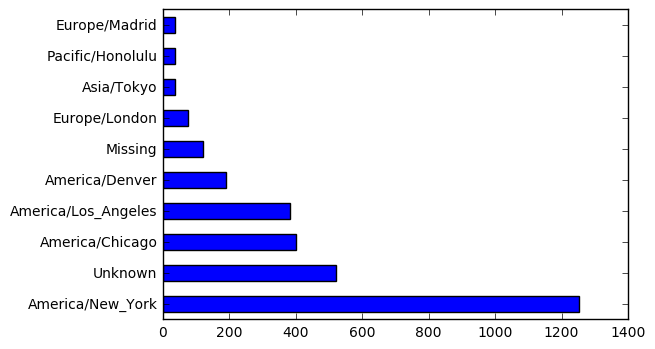

In [51]:
%matplotlib inline
tz_counts[:10].plot(kind='barh', rot=0)

我们还可以对这种数据进行更多的处理。比如a字段含有执行URL操作的浏览器、设备、应用程序的相关信息：

In [53]:
frame['a'][1]

'GoogleMaps/RochesterNY'

In [54]:
frame['a'][50]

'Mozilla/5.0 (Windows NT 5.1; rv:10.0.2) Gecko/20100101 Firefox/10.0.2'

In [55]:
frame['a'][51]

'Mozilla/5.0 (Linux; U; Android 2.2.2; en-us; LG-P925/V10e Build/FRG83G) AppleWebKit/533.1 (KHTML, like Gecko) Version/4.0 Mobile Safari/533.1'

In [58]:
frame['a'][:5]

0    Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
1                               GoogleMaps/RochesterNY
2    Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...
3    Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8)...
4    Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
Name: a, dtype: object

将这些USER_AGENT字符串中的所有信息都解析出来是一件挺郁闷的工作。不过只要掌握了Python内置的字符串函数和正则表达式，就方便了。比如，我们可以把字符串的第一节（与浏览器大致对应）分离出来得到另一份用户行为摘要：

In [59]:
results = Series([x.split()[0] for x in frame.a.dropna()])

In [60]:
results[:5]

0               Mozilla/5.0
1    GoogleMaps/RochesterNY
2               Mozilla/4.0
3               Mozilla/5.0
4               Mozilla/5.0
dtype: object

In [61]:
results.value_counts()[:8]

Mozilla/5.0                 2594
Mozilla/4.0                  601
GoogleMaps/RochesterNY       121
Opera/9.80                    34
TEST_INTERNET_AGENT           24
GoogleProducer                21
Mozilla/6.0                    5
BlackBerry8520/5.0.0.681       4
dtype: int64

现在，假设我们想按Windows和非Windows用户对时区统计信息进行分解。为了简单期间，我们假定只要agent字符串中含有“windows”就认为该用户是windows用户。由于有的agent缺失，所以先将他们从数据中移除：

In [62]:
cframe = frame[frame.a.notnull()]

其次根据a值计算出各行是否是windows：

In [66]:
operating_system = np.where(cframe['a'].str.contains('Windows'), 
                            'Windows', 'Not Windows')

In [67]:
operating_system[:5]

array(['Windows', 'Not Windows', 'Windows', 'Not Windows', 'Windows'], 
      dtype='<U11')

接下来就可以根据时区和新得到的操作系统列表对数据进行分组了：

In [68]:
by_tz_os = cframe.groupby(['tz', operating_system])

In [75]:
by_tz_os.size()

tz                                         
                                Not Windows    245
                                Windows        276
Africa/Cairo                    Windows          3
Africa/Casablanca               Windows          1
Africa/Ceuta                    Windows          2
Africa/Johannesburg             Windows          1
Africa/Lusaka                   Windows          1
America/Anchorage               Not Windows      4
                                Windows          1
America/Argentina/Buenos_Aires  Not Windows      1
America/Argentina/Cordoba       Windows          1
America/Argentina/Mendoza       Windows          1
America/Bogota                  Not Windows      1
                                Windows          2
America/Caracas                 Windows          1
America/Chicago                 Not Windows    115
                                Windows        285
America/Chihuahua               Not Windows      1
                                Window

然后通过size对分组结果进行计数（类似于上面的value_counts函数），并利用unstack对计数结果进行重塑：

In [76]:
agg_counts = by_tz_os.size().unstack().fillna(0)

In [77]:
agg_counts[:10]

,Not Windows,Windows
tz,,
,245.0,276.0
Africa/Cairo,0.0,3.0
Africa/Casablanca,0.0,1.0
Africa/Ceuta,0.0,2.0
Africa/Johannesburg,0.0,1.0
Africa/Lusaka,0.0,1.0
America/Anchorage,4.0,1.0
America/Argentina/Buenos_Aires,1.0,0.0
America/Argentina/Cordoba,0.0,1.0


最后，我们来选取最常出现的时区。为了达到这个目的，根据agg_counts中的行数构造了一个简洁索引数组：

In [82]:
indexer = agg_counts.sum(1)
indexer[:10]

tz
                                  521.0
Africa/Cairo                        3.0
Africa/Casablanca                   1.0
Africa/Ceuta                        2.0
Africa/Johannesburg                 1.0
Africa/Lusaka                       1.0
America/Anchorage                   5.0
America/Argentina/Buenos_Aires      1.0
America/Argentina/Cordoba           1.0
America/Argentina/Mendoza           1.0
dtype: float64

In [83]:
indexer = agg_counts.sum(1).argsort()
indexer[:10]

tz
                                  24
Africa/Cairo                      20
Africa/Casablanca                 21
Africa/Ceuta                      92
Africa/Johannesburg               87
Africa/Lusaka                     53
America/Anchorage                 54
America/Argentina/Buenos_Aires    57
America/Argentina/Cordoba         26
America/Argentina/Mendoza         55
dtype: int64

然后我通过take按照这个顺序截取了最后10行：

In [84]:
count_subset = agg_counts.take(indexer)[-10:]

In [85]:
count_subset

,Not Windows,Windows
tz,,
America/Sao_Paulo,13.0,20.0
Europe/Madrid,16.0,19.0
Pacific/Honolulu,0.0,36.0
Asia/Tokyo,2.0,35.0
Europe/London,43.0,31.0
America/Denver,132.0,59.0
America/Los_Angeles,130.0,252.0
America/Chicago,115.0,285.0
,245.0,276.0


这里也可以生成一张条形图。我们使用stacked=True来生成一张堆积条形图：

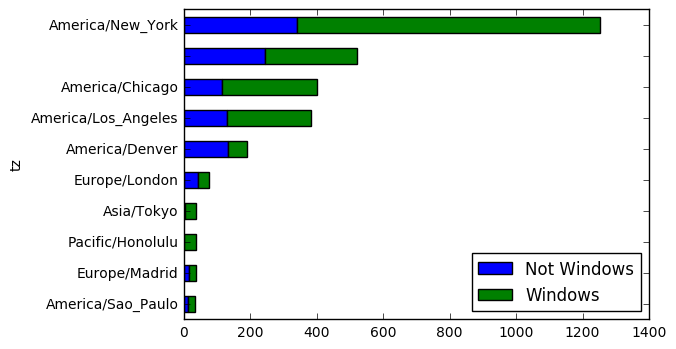

In [86]:
count_subset.plot(kind='barh', stacked=True)

由于这张图中不太容易看清楚较小分组中windows用户的相对比例，因此我们可以将各行规范化为“总计为1”并重新绘图：

In [87]:
normed_subset = count_subset.div(count_subset.sum(1), axis=0)

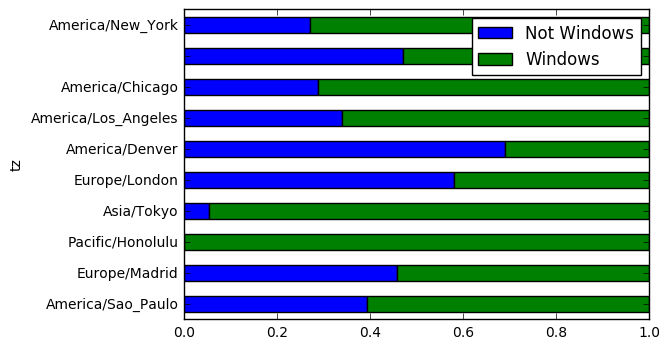

In [88]:
normed_subset.plot(kind='barh', stacked=True)

# MovieLens 1M数据集

这个数据集是电影评分数据：包括电影评分，电影元数据（风格类型，年代）以及关于用户的人口统计学数据（年龄，邮编，性别，职业等）。

MovieLens 1M数据集含有来自6000名用户对4000部电影的100万条评分数据。飞卫三个表：评分，用户信息，电影信息。这些数据都是dat文件格式，可以通过pandas.read_table将各个表分别读到一个pandas DataFrame对象中：

In [89]:
import pandas as pd

In [90]:
unames = ['user_id', 'gender', 'age', 'occupation', 'zip']

In [91]:
users = pd.read_table('../datasets/movielens/users.dat', sep='::', header=None, names=unames)

/Users/xu/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


因为sep='::'有点像是正则表达式，于是有了上面的错误。在这个[帖子](https://stackoverflow.com/questions/27301477/python-file-path-failing-in-pycharm-regex-confusion)找到了解决方法。

Looks like on Python 2.7 Pandas just doesn't handle separators that look regexish. The initial "error" can be worked around by adding engine='python' as a named parameter in the call, as suggested in the warning.



In [95]:
users = pd.read_table('../datasets/movielens/users.dat', sep='::', header=None, names=unames, engine='python')

In [110]:
rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_table('../datasets/movielens/ratings.dat', sep='::', header=None, names=rnames, engine='python')

In [125]:
mnames = ['movie_id', 'title', 'genres']
movies = pd.read_table('../datasets/movielens/movies.dat', sep='::', header=None, names=mnames, engine='python')

加载前几行验证一下数据加载工作是否顺利

In [126]:
users[:5]

,user_id,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [127]:
ratings[:5]

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [128]:
movies[:5]

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


注意，年龄和职业是以编码形式给出的，它们的具体含义请参考改数据集的REAMDE文件。分析散布在三个表中的数据不是一件轻松的事情。假设我们想要根据性别和年龄来计算某部电影的平均得分，如果将所有的数据都合并到一个表中的话，问题就简单多了。我们先用pandas的merge函数将ratings和users合并到一起，然后再将movies也合并进去。pandas会根据列名的重叠情况推断出哪些列是合并（或连接）键：

In [129]:
data = pd.merge(pd.merge(ratings, users), movies)

In [130]:
data.head()

,user_id,movie_id,rating,timestamp,gender,age,occupation,zip,title,genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,M,56,16,70072,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,M,25,12,32793,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,M,25,7,22903,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,M,50,1,95350,One Flew Over the Cuckoo's Nest (1975),Drama


In [135]:
data.ix[0]

user_id                                            1
movie_id                                        1193
rating                                             5
timestamp                                  978300760
gender                                             F
age                                                1
occupation                                        10
zip                                            48067
title         One Flew Over the Cuckoo's Nest (1975)
genres                                         Drama
Name: 0, dtype: object

现在，只要稍微熟悉一下pandas，就能轻松地根据任意个用户或电影属性对评分数据进行聚合操作了。为了按性别计算每部电影的平均得分，我们可以使用pivot_table方法：

In [139]:
mean_ratings = data.pivot_table('rating', index='title',
                                columns='gender', aggfunc='mean')

In [141]:
mean_ratings[:5]

gender,F,M
title,,
"$1,000,000 Duck (1971)",3.375000,2.761905
'Night Mother (1986),3.388889,3.352941
'Til There Was You (1997),2.675676,2.733333
"'burbs, The (1989)",2.793478,2.962085
...And Justice for All (1979),3.828571,3.689024


该操作产生了另一个DataFrame，其内容为电影平均得分，行标为电影名称，列表为性别。现在，我们打算过滤掉评分数据不够250条的电影（这个数字可以自己设定）。为了达到这个目的，我们先对title进行分组，然后利用size()得到一个含有各电影分组大小的Series对象：

In [142]:
ratings_by_title = data.groupby('title').size()

In [143]:
ratings_by_title[:10]

title
$1,000,000 Duck (1971)                37
'Night Mother (1986)                  70
'Til There Was You (1997)             52
'burbs, The (1989)                   303
...And Justice for All (1979)        199
1-900 (1994)                           2
10 Things I Hate About You (1999)    700
101 Dalmatians (1961)                565
101 Dalmatians (1996)                364
12 Angry Men (1957)                  616
dtype: int64

In [149]:
active_titles = ratings_by_title.index[ratings_by_title >= 250]

In [150]:
active_titles

Index([''burbs, The (1989)', '10 Things I Hate About You (1999)',
       '101 Dalmatians (1961)', '101 Dalmatians (1996)', '12 Angry Men (1957)',
       '13th Warrior, The (1999)', '2 Days in the Valley (1996)',
       '20,000 Leagues Under the Sea (1954)', '2001: A Space Odyssey (1968)',
       '2010 (1984)',
       ...
       'X-Men (2000)', 'Year of Living Dangerously (1982)',
       'Yellow Submarine (1968)', 'You've Got Mail (1998)',
       'Young Frankenstein (1974)', 'Young Guns (1988)',
       'Young Guns II (1990)', 'Young Sherlock Holmes (1985)',
       'Zero Effect (1998)', 'eXistenZ (1999)'],
      dtype='object', name='title', length=1216)

In [153]:
mean_ratings = mean_ratings.ix[active_titles]
mean_ratings.head()

gender,F,M
title,,
"'burbs, The (1989)",2.793478,2.962085
10 Things I Hate About You (1999),3.646552,3.311966
101 Dalmatians (1961),3.791444,3.500000
101 Dalmatians (1996),3.240000,2.911215
12 Angry Men (1957),4.184397,4.328421


In [155]:
top_female_ratings = mean_ratings.sort_values(by='F', ascending=False)
top_female_ratings[:10]

gender,F,M
title,,
"Close Shave, A (1995)",4.644444,4.473795
"Wrong Trousers, The (1993)",4.588235,4.478261
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),4.572650,4.464589
Wallace & Gromit: The Best of Aardman Animation (1996),4.563107,4.385075
Schindler's List (1993),4.562602,4.491415
"Shawshank Redemption, The (1994)",4.539075,4.560625
"Grand Day Out, A (1992)",4.537879,4.293255
To Kill a Mockingbird (1962),4.536667,4.372611
Creature Comforts (1990),4.513889,4.272277


## 计算评分分歧

假设我们想要找出男性和女性观众分歧最大的电影。一个办法是给mean_ratings加上一个用于存放平均得分之差的列，并对其进行排序：

In [156]:
mean_ratings['diff'] = mean_ratings['M'] - mean_ratings['F']

按‘diff’排序即可得到分歧最大且女性观众更喜欢的电影：

In [159]:
sorted_by_diff = mean_ratings.sort_values(by='diff')
sorted_by_diff[:15]

gender,F,M,diff
title,,,
Dirty Dancing (1987),3.790378,2.959596,-0.830782
Jumpin' Jack Flash (1986),3.254717,2.578358,-0.676359
Grease (1978),3.975265,3.367041,-0.608224
Little Women (1994),3.870588,3.321739,-0.548849
Steel Magnolias (1989),3.901734,3.365957,-0.535777
Anastasia (1997),3.800000,3.281609,-0.518391
"Rocky Horror Picture Show, The (1975)",3.673016,3.160131,-0.512885
"Color Purple, The (1985)",4.158192,3.659341,-0.498851
"Age of Innocence, The (1993)",3.827068,3.339506,-0.487561


对行反序，并取出前15行，得到的则是男性更喜欢的电影

In [160]:
sorted_by_diff[::-1][:15]

gender,F,M,diff
title,,,
"Good, The Bad and The Ugly, The (1966)",3.494949,4.221300,0.726351
"Kentucky Fried Movie, The (1977)",2.878788,3.555147,0.676359
Dumb & Dumber (1994),2.697987,3.336595,0.638608
"Longest Day, The (1962)",3.411765,4.031447,0.619682
"Cable Guy, The (1996)",2.250000,2.863787,0.613787
Evil Dead II (Dead By Dawn) (1987),3.297297,3.909283,0.611985
"Hidden, The (1987)",3.137931,3.745098,0.607167
Rocky III (1982),2.361702,2.943503,0.581801
Caddyshack (1980),3.396135,3.969737,0.573602


如果只是想要找出分歧最大的电影（不考虑性别因素），则可以计算得分数据的方差或标准差：

In [162]:
# 根据电影名称分组的得分数据的标准差
rating_std_by_title = data.groupby('title')['rating'].std()

In [163]:
# 根据active_titles进行过滤
rating_std_by_title = rating_std_by_title.ix[active_titles]

In [165]:
rating_std_by_title.sort_values(ascending=False)[:10]

title
Dumb & Dumber (1994)                     1.321333
Blair Witch Project, The (1999)          1.316368
Natural Born Killers (1994)              1.307198
Tank Girl (1995)                         1.277695
Rocky Horror Picture Show, The (1975)    1.260177
Eyes Wide Shut (1999)                    1.259624
Evita (1996)                             1.253631
Billy Madison (1995)                     1.249970
Fear and Loathing in Las Vegas (1998)    1.246408
Bicentennial Man (1999)                  1.245533
Name: rating, dtype: float64

In [167]:
movies[:5]

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


这里我们注意到，电影分类是以竖线`|`分割的字符串形式给出的。如果想对电影分类进行分析的话，就需要先将其转换成更有用的形式才行。我将在本书后续章节中讲到这种转换处理，到时候还会再用到这个数据。

# 1880-2010年间全美婴儿姓名

这个数据时从1880年到2010年婴儿名字频率数据。这个数据集可以用来做很多事，例如：

- 计算指定名字的年度比例
- 计算某个名字的相对排名
- 计算各年度最流行的名字，以及增长或减少最快的名字
- 分析名字趋势：元音、辅音、长度、总体多样性、拼写变化、首尾字母等
- 分析外源性趋势：圣经中的名字、名人、人口结构变化等

在babynames文件夹下可以看到这些文件是按年度来编号的

In [168]:
!head -n 10 ../datasets/babynames/yob1880.txt

由于这是一个非常标准的以逗号隔开的格式（即CSV文件），所以可以用pandas.read_csv将其加载到DataFrame中：

In [169]:
import pandas as pd

In [170]:
names1880 = pd.read_csv('../datasets/babynames/yob1880.txt', names=['names', 'sex', 'births'])

In [172]:
names1880.head()

,names,sex,births
0,Mary,F,7065
1,Anna,F,2604
2,Emma,F,2003
3,Elizabeth,F,1939
4,Minnie,F,1746


这些文件中仅含有当年出现超过5次的名字。为了简单期间，我们可以用births列的sex分组小计，表示该年度的births总计：

In [173]:
names1880.groupby('sex').births.sum()

sex
F     90993
M    110493
Name: births, dtype: int64

由于该数据集按年度被分割成了多个文件，所以第一件事情就是要将所有数据都组装到一个DataFrame里面，并加上一个year字段。使用pandas.concat可以做到：

In [174]:
# 2010是最后一个有效统计年度
years = range(1880, 2011)

pieces = []
columns = ['name', 'sex', 'births']

for year in years:
    path = '../datasets/babynames/yob%d.txt' % year
    frame = pd.read_csv(path, names=columns)
    
    frame['year'] = year
    pieces.append(frame)
    
# 将所有数据整合到单个DataFrame中
names = pd.concat(pieces, ignore_index=True)

这里要注意几件事。

- 第一，concat默认是按行将多个DataFrame组合到一起的；
- 第二，必须指定ignore_index=True，因为我们不希望保留read_csv所返回的原始行号。

现在我们得到了一个非常大的DataFrame，它含有全部的名字数据。现在names这个DataFrame看上去是：

In [179]:
names[:5]

,name,sex,births,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880


有了这些数据后，我们就可以利用groupby或pivot_table在year和sex界别上对其进行聚合了：

In [180]:
total_births = names.pivot_table('births', index='year',
                                columns='sex', aggfunc=sum)

In [181]:
total_births.tail()

sex,F,M
year,,
2006,1896468,2050234
2007,1916888,2069242
2008,1883645,2032310
2009,1827643,1973359
2010,1759010,1898382


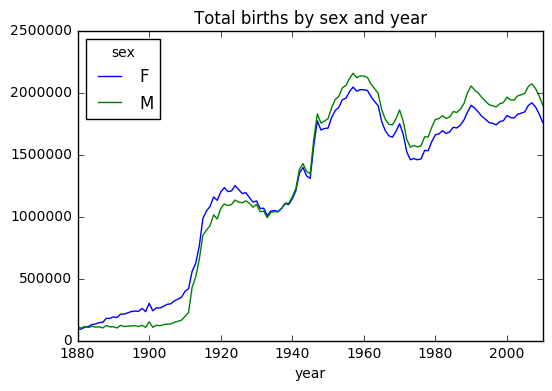

In [182]:
total_births.plot(title='Total births by sex and year')

下面我们来插入一个prop列，用于存放指定名字的婴儿数相对于总出生数的比列。prop值为0.02表示每100名婴儿中有2名去了当前这个名字。因此，我们先按year和sex分组，然后再将新列加到各个分组上：

In [185]:
def add_prop(group):
    # 整数出发回向下圆整
    # births = group.births.astype(float)
    births = group.births
    
    group['prop'] = births / births.sum()
    return group

names = names.groupby(['year', 'sex']).apply(add_prop)

注意：由于births是整数，所以我们在计算分式时必须将分子或分母转换成浮点数（除非使用的是python3）。所以上面我们可以不加`births = group.births.astype(float)`这一句代码。

In [188]:
names[:5]

,name,sex,births,year,prop
0,Mary,F,7065,1880,0.077643
1,Anna,F,2604,1880,0.028618
2,Emma,F,2003,1880,0.022013
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188


在执行这样的分组处理时，一般都应该做一些有效性检查，比如验证所有分组的prop的综合是否为1。由于这是一个浮点型数据，所以我们应该用np.allclose来检查这个分组总计值是否够近似于（可能不会精确等于）1：

In [189]:
np.allclose(names.groupby(['year', 'sex']).prop.sum(), 1)

True

这样就算完活了。为了便于实现进一步的分析，我们需要取出该数据的一个子集：每对sex/year组合的前1000个名字。这又是一个分组操作：

In [193]:
def get_top1000(group):
    return group.sort_values(by='births', ascending=False)[:1000]

grouped = names.groupby(['year', 'sex'])
top1000 = grouped.apply(get_top1000)

如果喜欢DIY的话，也可以这样：

In [195]:
pieces =[]
for year, group in names.groupby(['year', 'sex']):
    pieces.append(group.sort_values(by='births', ascending=False)[:1000])
    
top1000 = pd.concat(pieces, ignore_index=True)

In [197]:
top1000[:10]

,name,sex,births,year,prop
0,Mary,F,7065,1880,0.077643
1,Anna,F,2604,1880,0.028618
2,Emma,F,2003,1880,0.022013
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188
5,Margaret,F,1578,1880,0.017342
6,Ida,F,1472,1880,0.016177
7,Alice,F,1414,1880,0.015540
8,Bertha,F,1320,1880,0.014507
9,Sarah,F,1288,1880,0.014155


接下来的数据分析工作就针对这个top1000数据集了

## 分析命名趋势

有了完整的数据集和刚才生成的top1000数据集，我们就可以开始分析各种命名趋势了。首先将前1000个名字分为男女两个部分：


In [199]:
boys = top1000[top1000.sex=='M']
girls = top1000[top1000.sex=='F']

这是两个简单的时间序列，只需要稍作整理即可绘制出相应的图标（比如每年叫做John和Mary的婴儿数）。我们先生成一张按year和name统计的总出生数透视表：

In [202]:
total_births = top1000.pivot_table('births', index='year', 
                                   columns='name', aggfunc=sum)

total_births[:5]

name,Aaden,Aaliyah,Aarav,Aaron,Aarush,Ab,Abagail,Abb,Abbey,Abbie,...,Zoa,Zoe,Zoey,Zoie,Zola,Zollie,Zona,Zora,Zula,Zuri
year,,,,,,,,,,,,,,,,,,,,,
1880,NaN,NaN,NaN,102.0,NaN,NaN,NaN,NaN,NaN,71.0,...,8.0,23.0,NaN,NaN,7.0,NaN,8.0,28.0,27.0,NaN
1881,NaN,NaN,NaN,94.0,NaN,NaN,NaN,NaN,NaN,81.0,...,NaN,22.0,NaN,NaN,10.0,NaN,9.0,21.0,27.0,NaN
1882,NaN,NaN,NaN,85.0,NaN,NaN,NaN,NaN,NaN,80.0,...,8.0,25.0,NaN,NaN,9.0,NaN,17.0,32.0,21.0,NaN
1883,NaN,NaN,NaN,105.0,NaN,NaN,NaN,NaN,NaN,79.0,...,NaN,23.0,NaN,NaN,10.0,NaN,11.0,35.0,25.0,NaN
1884,NaN,NaN,NaN,97.0,NaN,NaN,NaN,NaN,NaN,98.0,...,13.0,31.0,NaN,NaN,14.0,6.0,8.0,58.0,27.0,NaN


In [203]:
subset = total_births[['John', 'Harry', 'Mary', 'Marilyn']]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1140cbd30>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1217b7630>], dtype=object)

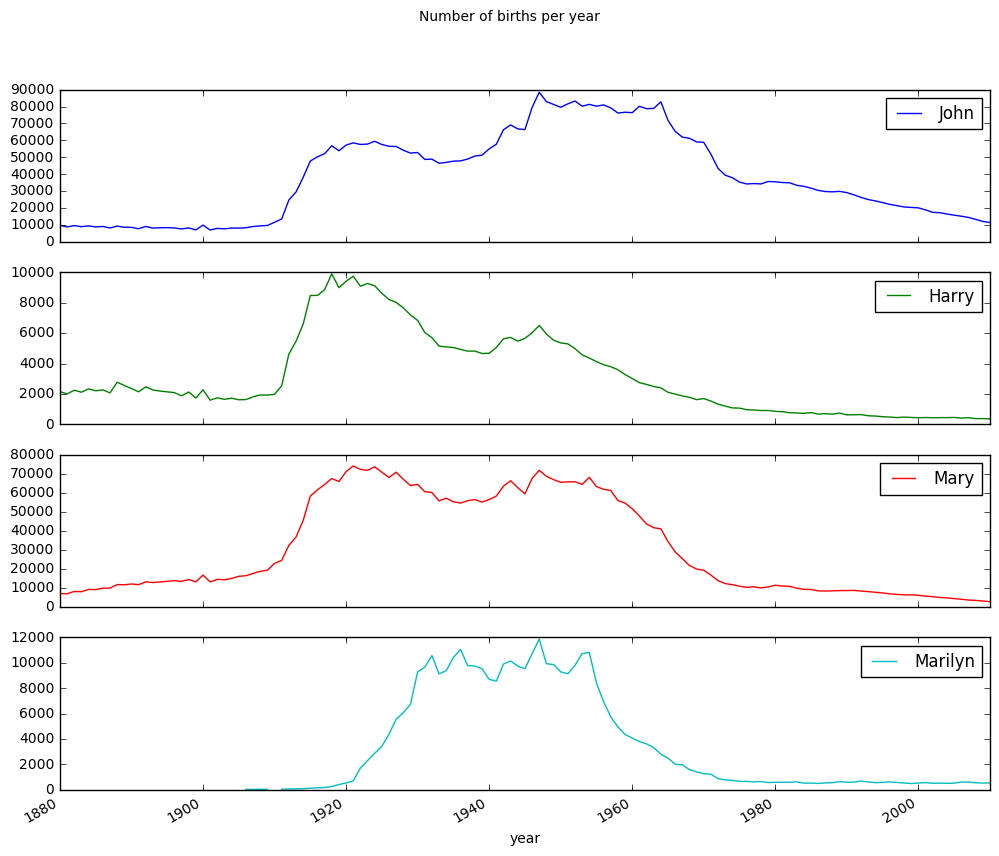

In [205]:
subset.plot(subplots=True, figsize=(12, 10), grid=False,
            title="Number of births per year")

## 评价命名多样性的增长

上图反应的降低情况可能意味着父母愿意给小孩起常见的名字越来越少。这个假设可以从数据中得到验证。一个办法是计算最流行的1000个名字所占的比例，我按year和sex进行聚合并绘图：

In [206]:
table = top1000.pivot_table('prop', index='year',
                           columns='sex', aggfunc=sum)

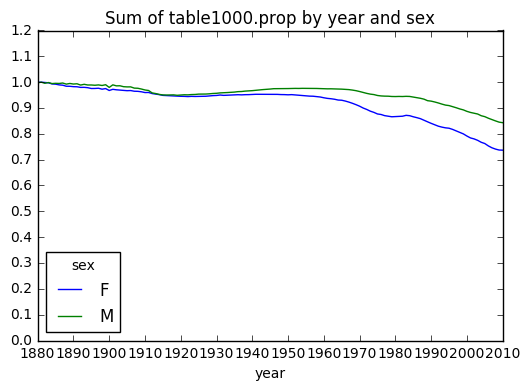

In [207]:
table.plot(title='Sum of table1000.prop by year and sex',
           yticks=np.linspace(0, 1.2, 13), xticks=range(1880, 2020, 10))

从图中可以看出，名字的多样性确实出现了增长（前1000项的比例降低）。另一个办法是计算占总出生人数前50%的不同名字的数量，这个数字不太好计算。我们只考虑2010年男孩的名字：

In [208]:
df = boys[boys.year == 2010]

In [210]:
df[:5]

,name,sex,births,year,prop
260877,Jacob,M,21875,2010,0.011523
260878,Ethan,M,17866,2010,0.009411
260879,Michael,M,17133,2010,0.009025
260880,Jayden,M,17030,2010,0.008971
260881,William,M,16870,2010,0.008887


对prop降序排列后，我们想知道前面多少个名字的人数加起来才够50%。虽然编写一个for循环也能达到目的，但NumPy有一种更聪明的矢量方式。先计算prop的累计和cumsum，，然后再通过searchsorted方法找出0.5应该被插入在哪个位置才能保证不破坏顺序：

In [211]:
prop_cumsum = df.sort_values(by='prop', ascending=False).prop.cumsum()

In [212]:
prop_cumsum[:10]

260877    0.011523
260878    0.020934
260879    0.029959
260880    0.038930
260881    0.047817
260882    0.056579
260883    0.065155
260884    0.073414
260885    0.081528
260886    0.089621
Name: prop, dtype: float64

In [214]:
prop_cumsum.searchsorted(0.5)

array([116])

由于数组索引是从0开始的，因此我们要给这个结果加1，即最终结果为117.拿1900年的数据来做个比较，这个数字要小得多：

In [217]:
df = boys[boys.year == 1900]
in1900 = df.sort_values(by='prop', ascending=False).prop.cumsum()
in1900[-10:]

41853    0.979223
41852    0.979277
41851    0.979330
41850    0.979383
41849    0.979436
41848    0.979489
41847    0.979542
41846    0.979595
41845    0.979648
41876    0.979702
Name: prop, dtype: float64

In [218]:
in1900.searchsorted(0.5) + 1

array([25])

现在就可以对所有year/sex组合执行这个计算了。按这两个字段进行groupby处理，然后用一个函数计算各分组的这个值：

In [220]:
def get_quantile_count(group, q=0.5):
    group = group.sort_values(by='prop', ascending=False)
    return group.prop.cumsum().searchsorted(q) + 1

diversity = top1000.groupby(['year', 'sex']).apply(get_quantile_count)
diversity = diversity.unstack('sex')

现在，这个diversity有两个时间序列（每个性别各一个，按年度索引）。通过IPython，可以看到其内容，还可以绘制图标

In [221]:
diversity.head()

sex,F,M
year,,
1880,[38],[14]
1881,[38],[14]
1882,[38],[15]
1883,[39],[15]
1884,[39],[16]


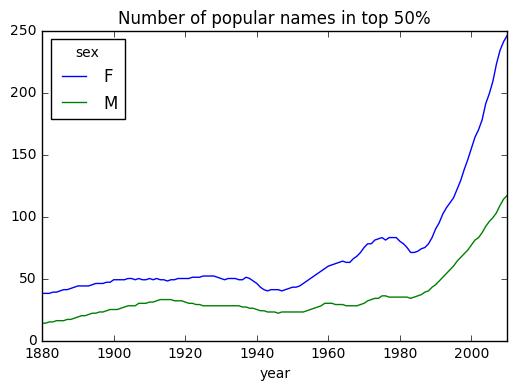

In [223]:
diversity=diversity.astype(float)

diversity.plot(title='Number of popular names in top 50%')

In [225]:
diversity[:5]

sex,F,M
year,,
1880,38.0,14.0
1881,38.0,14.0
1882,38.0,15.0
1883,39.0,15.0
1884,39.0,16.0


> 注意，如果不加`diversity=diversity.astype(float)`的话，会报错显示，“no numeric data to plot” error。通过加上这句来更改数据类型，就能正常绘图了。

从图中可以看出，女孩名字的多样性总是比男孩高，而且还变得越来越高。我们可以自己分析一下具体是什么在驱动这个多样性（比如拼写形式的变化）。

## “最后一个字母”的变革

一位研究人员指出：近百年来，男孩名字在最后一个字母上的分布发生了显著的变化。为了了解具体的情况，我们首先将全部出生数据在年度、性别以及末字母上进行了聚合：

In [226]:
# 从name列中取出最后一个字母
get_last_letter = lambda x: x[-1]
last_letters = names.name.map(get_last_letter)
last_letters.name = 'last_letter'

table = names.pivot_table('births', index=last_letters,
                          columns=['sex', 'year'], aggfunc=sum)

In [229]:
print(type(last_letters))
print(last_letters[:5])

<class 'pandas.core.series.Series'>
0    y
1    a
2    a
3    h
4    e
Name: last_letter, dtype: object


然后，我选出具有一个代表性的三年，并输出前几行：

In [230]:
subtable = table.reindex(columns=[1910, 1960, 2010], level='year')
subtable.head()

sex                 F                            M                    
year             1910      1960      2010     1910      1960      2010
last_letter                                                           
a            108376.0  691247.0  670605.0    977.0    5204.0   28438.0
b                 NaN     694.0     450.0    411.0    3912.0   38859.0
c                 5.0      49.0     946.0    482.0   15476.0   23125.0
d              6750.0    3729.0    2607.0  22111.0  262112.0   44398.0
e            133569.0  435013.0  313833.0  28655.0  178823.0  129012.0

接下来我们需要安总出生数对该表进行规范化处理，一遍计算出个性别各末字母站总出生人数的比例：

In [231]:
subtable.sum()

sex  year
F    1910     396416.0
     1960    2022062.0
     2010    1759010.0
M    1910     194198.0
     1960    2132588.0
     2010    1898382.0
dtype: float64

In [233]:
letter_prop = subtable / subtable.sum()
letter_prop

sex                 F                             M                    
year             1910      1960      2010      1910      1960      2010
last_letter                                                            
a            0.273390  0.341853  0.381240  0.005031  0.002440  0.014980
b                 NaN  0.000343  0.000256  0.002116  0.001834  0.020470
c            0.000013  0.000024  0.000538  0.002482  0.007257  0.012181
d            0.017028  0.001844  0.001482  0.113858  0.122908  0.023387
e            0.336941  0.215133  0.178415  0.147556  0.083853  0.067959
f                 NaN  0.000010  0.000055  0.000783  0.004325  0.001188
g            0.000144  0.000157  0.000374  0.002250  0.009488  0.001404
h            0.051529  0.036224  0.075852  0.045562  0.037907  0.051670
i            0.001526  0.039965  0.031734  0.000844  0.000603  0.022628
j                 NaN       NaN  0.000090       NaN       NaN  0.000769
k            0.000121  0.000156  0.000356  0.036581  0.049384  0.018541
l            0.043189  0.033867  0.026356  0.065016  0.104904  0.070367
m            0.001201  0.008613  0.002588  0.058044  0.033827  0.024657
n            0.079240  0.130687  0.140210  0.143415  0.152522  0.362771
o            0.001660  0.002439  0.001243  0.017065  0.012829  0.042681
p            0.000018  0.000023  0.000020  0.003172  0.005675  0.001269
q                 NaN       NaN  0.000030       NaN       NaN  0.000180
r            0.013390  0.006764  0.018025  0.064481  0.031034  0.087477
s            0.039042  0.012764  0.013332  0.130815  0.102730  0.065145
t            0.027438  0.015201  0.007830  0.072879  0.065655  0.022861
u            0.000684  0.000574  0.000417  0.000124  0.000057  0.001221
v                 NaN  0.000060  0.000117  0.000113  0.000037  0.001434
w            0.000020  0.000031  0.001182  0.006329  0.007711  0.016148
x            0.000015  0.000037  0.000727  0.003965  0.001851  0.008614
y            0.110972  0.152569  0.116828  0.077349  0.160987  0.058168
z            0.002439  0.000659  0.000704  0.000170  0.000184  0.001831

有了这个字母比例数据后，就可以生成一张各年度各性别的条形图了：

In [236]:
import matplotlib.pyplot as plt

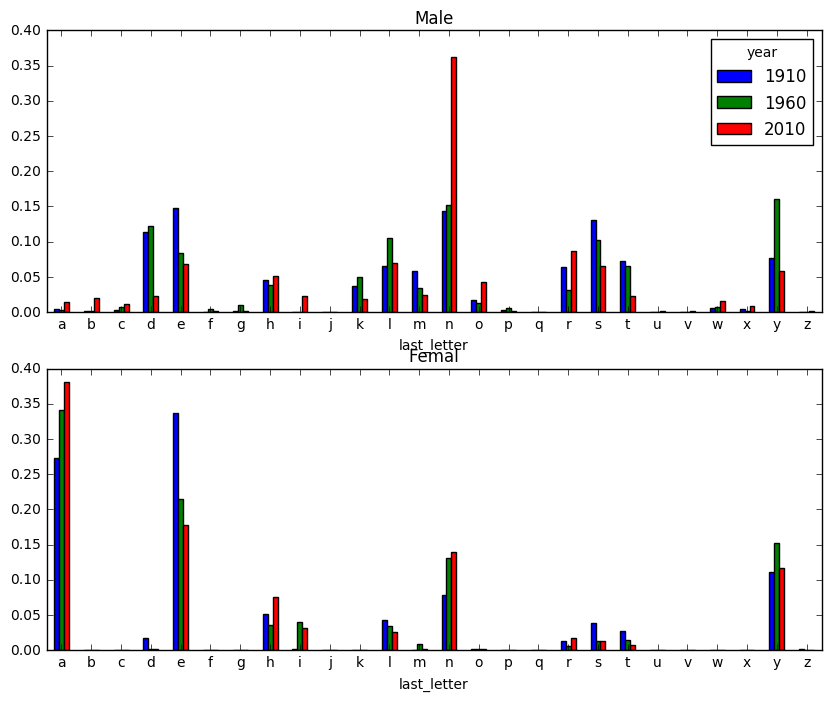

In [240]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
letter_prop['M'].plot(kind='bar', rot=0, ax=axes[0], title='Male')
letter_prop['F'].plot(kind='bar', rot=0, ax=axes[1], title='Femal', legend=False)

从上图可以看出来，从20世纪60年代开始，以字母'n'结尾的男孩名字出现了显著的增长。回到之前创建的那个完整表，按年度和性别对其进行规范化处理，并在男孩名字中选取几个字母，最后进行转置以便将各个列做成一个时间序列：

In [242]:
# table = top1000.pivot_table('prop', index='year',
#                            columns='sex', aggfunc=sum)

letter_prop = table / table.sum()
letter_prop.head()

sex                 F                                                    \
year             1880      1881      1882      1883      1884      1885   
last_letter                                                               
a            0.345587  0.343440  0.338764  0.341251  0.338550  0.341270   
b                 NaN       NaN       NaN       NaN       NaN       NaN   
c                 NaN       NaN  0.000046  0.000045       NaN       NaN   
d            0.006693  0.006601  0.006806  0.007211  0.007100  0.006478   
e            0.366819  0.370616  0.374582  0.373159  0.372722  0.372896   

sex                                                    ...            M  \
year             1886      1887      1888      1889    ...         2001   
last_letter                                            ...                
a            0.339703  0.335258  0.332764  0.328706    ...     0.020162   
b                 NaN       NaN       NaN       NaN    ...     0.026256   
c                 NaN       NaN       NaN       NaN    ...     0.013972   
d            0.006967  0.007035  0.007266  0.007703    ...     0.031352   
e            0.372802  0.372324  0.373675  0.373736    ...     0.074927   

sex                                                                      \
year             2002      2003      2004      2005      2006      2007   
last_letter                                                               
a            0.020019  0.019177  0.019505  0.018481  0.017635  0.016747   
b            0.025418  0.024368  0.023171  0.021645  0.020778  0.020357   
c            0.014048  0.014042  0.013514  0.013083  0.012991  0.012983   
d            0.028794  0.027069  0.026118  0.025420  0.025075  0.024451   
e            0.074603  0.073396  0.071710  0.070799  0.069748  0.069445   

sex                                        
year             2008      2009      2010  
last_letter                                
a            0.016189  0.015927  0.014980  
b            0.019655  0.019693  0.020470  
c            0.012458  0.012186  0.012181  
d            0.023574  0.023398  0.023387  
e            0.069362  0.068663  0.067959  

[5 rows x 262 columns]

In [245]:
dny_ts = letter_prop.ix[['d', 'n', 'y'], 'M'].T
dny_ts.head()

last_letter,d,n,y
year,,,
1880,0.083055,0.153213,0.075760
1881,0.083247,0.153214,0.077451
1882,0.085340,0.149560,0.077537
1883,0.084066,0.151646,0.079144
1884,0.086120,0.149915,0.080405


有了这个时间序列的DataFrame后，就可以通过其plot方法绘制出一张趋势图：

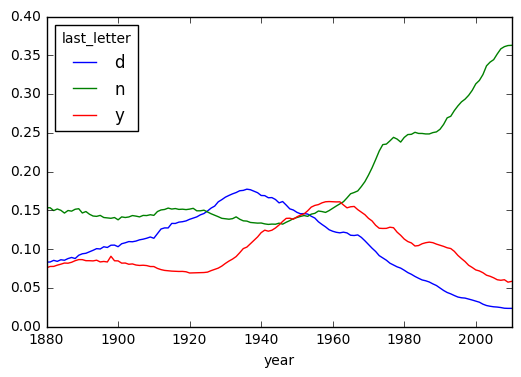

In [246]:
dny_ts.plot()

## 变成女孩名字的男孩名字（以及相反的情况）

另一个有趣的趋势是，早年流行于男孩的名字近年来“变性了”，列入Lesley或Leslie。回到top1000数据集，找出其中以"lesl"开头的一组名字：

In [247]:
all_names = top1000.name.unique()
mask = np.array(['lesl' in x.lower() for x in all_names])
lesley_like = all_names[mask]
lesley_like

array(['Leslie', 'Lesley', 'Leslee', 'Lesli', 'Lesly'], dtype=object)

然后利用这个结果过滤其他的名字，并按名字分组计算出生数以查看相对频率：

In [248]:
filtered = top1000[top1000.name.isin(lesley_like)]
filtered.groupby('name').births.sum()

name
Leslee      1082
Lesley     35022
Lesli        929
Leslie    370429
Lesly      10067
Name: births, dtype: int64

接下来，我们按性别和年度进行聚合，并按年度进行规范化处理：

In [253]:
table = filtered.pivot_table('births', index='year',
                             columns='sex', aggfunc='sum')

table[:5]

sex,F,M
year,,
1880,8.0,79.0
1881,11.0,92.0
1882,9.0,128.0
1883,7.0,125.0
1884,15.0,125.0


In [254]:
table = table.div(table.sum(1), axis=0)
table[:5]

sex,F,M
year,,
1880,0.091954,0.908046
1881,0.106796,0.893204
1882,0.065693,0.934307
1883,0.053030,0.946970
1884,0.107143,0.892857


In [251]:
table.tail()

sex,F,M
year,,
2006,1.0,NaN
2007,1.0,NaN
2008,1.0,NaN
2009,1.0,NaN
2010,1.0,NaN


现在，我们可以轻松绘制一张分性别的年度曲线图了：

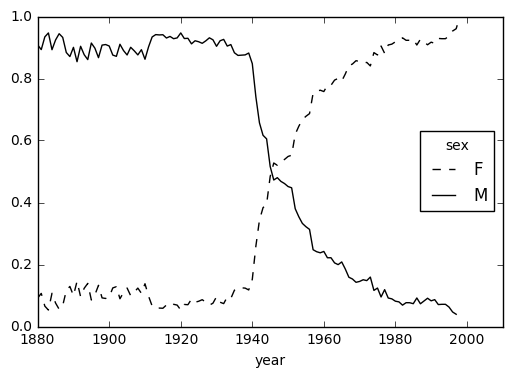

In [255]:
table.plot(style={'M': 'k-', 'F': 'k--'})